## Bayesian Graph Neural Networks: Binary Classification given Molecular Data

### Load Libraries

In [1]:
import jraph 
import jax
import pickle
import networkx as nx
import optax
import jax.numpy as jnp
import functools
import numpyro 
import numpy as np
import matplotlib.pyplot as plt
import numpyro.distributions as dist

from flax import linen as nn
from typing import Sequence
from typing import Any, Callable, Dict, List, Optional, Tuple
from numpyro.contrib.module import random_flax_module
from numpyro.infer import MCMC, NUTS, Predictive, init_to_feasible, init_to_value
from sklearn import metrics
from clu import parameter_overview

In [2]:
# Download jraph version of MUTAG.
# !wget -P tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle

In [3]:
# Utility functions stolen from Jraph introductory colab

def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
    nodes, edges, receivers, senders, _, _, _ = jraph_graph
    nx_graph = nx.DiGraph()
    if nodes is None:
        for n in range(jraph_graph.n_node[0]):
          nx_graph.add_node(n)
    else:
        for n in range(jraph_graph.n_node[0]):
          nx_graph.add_node(n, node_feature=nodes[n])
    if edges is None:
        for e in range(jraph_graph.n_edge[0]):
          nx_graph.add_edge(int(senders[e]), int(receivers[e]))
    else:
        for e in range(jraph_graph.n_edge[0]):
          nx_graph.add_edge(
              int(senders[e]), int(receivers[e]), edge_feature=edges[e])
    return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
    nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
    pos = nx.spring_layout(nx_graph)
    nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

In [4]:
# Load Data

with open('tmp/mutag.pickle', 'rb') as f:
    mutag_ds = pickle.load(f)
    
# Assign train and test sets

train_mutag_ds = mutag_ds[:150]
test_mutag_ds = mutag_ds[150:]

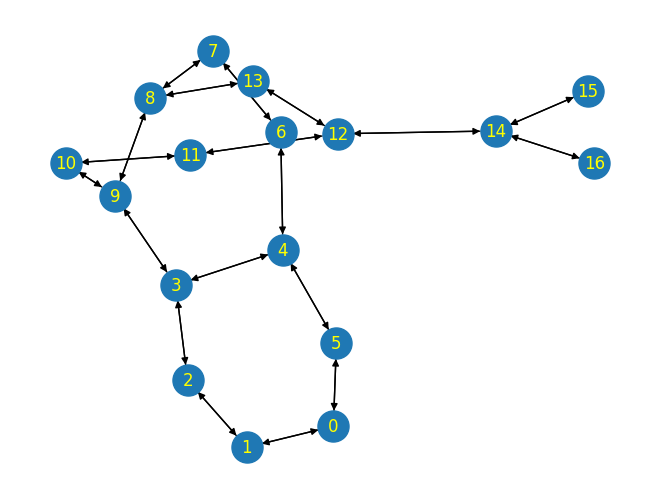

In [5]:
draw_jraph_graph_structure(train_mutag_ds[0]['input_graph'])

In [6]:
# Graph Padding - Ignored entirely in the Bayesian formulation (not needed for speed right now)

def _nearest_bigger_power_of_two(x: int) -> int:
    """Computes the nearest power of two greater than x for padding."""
    y = 2
    while y < x:
        y *= 2
    return y

def pad_graph_to_nearest_power_of_two(
    graphs_tuple: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Pads a batched `GraphsTuple` to the nearest power of two.
    For example, if a `GraphsTuple` has 7 nodes, 5 edges and 3 graphs, this method
    would pad the `GraphsTuple` nodes and edges:
    7 nodes --> 8 nodes (2^3)
    5 edges --> 8 edges (2^3)
    And since padding is accomplished using `jraph.pad_with_graphs`, an extra
    graph and node is added:
    8 nodes --> 9 nodes
    3 graphs --> 4 graphs
    Args:
    graphs_tuple: a batched `GraphsTuple` (can be batch size 1).
    Returns:
    A graphs_tuple batched to the nearest power of two.
    """
    # Add 1 since we need at least one padding node for pad_with_graphs.
    pad_nodes_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_node)) + 1
    pad_edges_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_edge))
    # Add 1 since we need at least one padding graph for pad_with_graphs.
    # We do not pad to nearest power of two because the batch size is fixed.
    pad_graphs_to = graphs_tuple.n_node.shape[0] + 1
    return jraph.pad_with_graphs(
        graphs_tuple, 
        pad_nodes_to, 
        pad_edges_to,
        pad_graphs_to
    )

In [7]:
# Definition of model class using Jraph and Flax

class ExplicitMLP(nn.Module):
    """A flax MLP."""
    features: Sequence[int]

    @nn.compact
    def __call__(self, inputs):
        x = inputs
        for i, lyr in enumerate([nn.Dense(feat) for feat in self.features]):
          x = lyr(x)
          if i != len(self.features) - 1:
            x = nn.relu(x)
        return x
    
def make_embed_fn(latent_size):
    def embed(inputs):
        return nn.Dense(latent_size)(inputs)
    return embed

def make_mlp(features):
    @jraph.concatenated_args
    def update_fn(inputs):
        return ExplicitMLP(features)(inputs)
    return update_fn

class GraphNetwork(nn.Module):
    """A flax GraphNetwork."""
    mlp_features: Sequence[int]
    latent_size: int

    @nn.compact
    def __call__(self, graph):
    
        # Add a global parameter for graph classification computation
        
        graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))

        embedder = jraph.GraphMapFeatures(
            embed_node_fn=make_embed_fn(self.latent_size),
            embed_edge_fn=make_embed_fn(self.latent_size),
            embed_global_fn=make_embed_fn(self.latent_size))
        
        net = jraph.GraphNetwork(
            update_node_fn=make_mlp(self.mlp_features),
            update_edge_fn=make_mlp(self.mlp_features),
            update_global_fn=make_mlp(self.mlp_features + (1,)))  # pytype: disable=unsupported-operands

        return net(embedder(graph))

### Modifications for NumPyro specifically

In [15]:
numpyro.set_platform('cpu')

In [16]:
# Obtain targets for training and testing

y_train = np.zeros(shape=(len(train_mutag_ds, )))
y_test = np.zeros(shape=len(test_mutag_ds,))
                    
for idx, obj in enumerate(train_mutag_ds):
    y_train[idx] = obj['target']
    
for idx, obj in enumerate(test_mutag_ds):
    y_test[idx] = obj['target']
    
y_train = jnp.array(y_train)
y_test = jnp.array(y_test)

In [17]:
# Batch graphs for ease of predictions in the forward pass

train_mutag_batch = jraph.batch([g['input_graph'] for g in train_mutag_ds])
test_mutag_batch = jraph.batch([g['input_graph'] for g in test_mutag_ds])

In [18]:
# Define model

def numpyro_model(batch_of_graphs, target, init_graph):
    
    # Define base flax module

    module = GraphNetwork(mlp_features=[16, 16], latent_size=16)
    
    # Register as a random flax module (parameter inference done outside)
    # TODO: check if graph argument makes sense. Would it just keep the graph static?
    
    net = random_flax_module(
        "Mutag_GraphNet_Model",
        module,
        prior = dist.StudentT(df=4.0, scale=0.1),
        input_shape=None, 
        graph=init_graph,
    )

    # Faster forward pass
    
    pred_graph = net(batch_of_graphs)
    preds = pred_graph.globals.flatten()
    prob = jax.nn.sigmoid(preds) # this is a sigmoid function for binary classification
    numpyro.deterministic("prob", prob)
    
    return numpyro.sample("y_pred", dist.Bernoulli(prob), obs=target)
    
# Initialize model

model2 = GraphNetwork(mlp_features=[16, 16], latent_size=16)
key = jax.random.PRNGKey(0)
params = model2.init(key, train_mutag_ds[0]['input_graph'])
print(parameter_overview.get_parameter_overview(params))
del model2

# Initialize MCMC

# kernel = NUTS(model, init_strategy=init_to_value(values=init_new), target_accept_prob=0.70)
kernel = NUTS(numpyro_model, 
              init_strategy = init_to_feasible(), # init_to_value(values=variables), # init_to_uniform(), 
              target_accept_prob=0.80,
              max_tree_depth=10,
              )

mcmc = MCMC(
    kernel,
    num_warmup=100,
    num_samples=100,
    num_chains=1,
    progress_bar=True, # TOGGLE this...
    chain_method="vectorized", # "vectorized"
)

+-------------------------------------+----------+-------+-----------+-------+
| Name                                | Shape    | Size  | Mean      | Std   |
+-------------------------------------+----------+-------+-----------+-------+
| params/Dense_0/bias                 | (16,)    | 16    | 0.0       | 0.0   |
| params/Dense_0/kernel               | (7, 16)  | 112   | -0.0086   | 0.412 |
| params/Dense_1/bias                 | (16,)    | 16    | 0.0       | 0.0   |
| params/Dense_1/kernel               | (4, 16)  | 64    | 0.036     | 0.556 |
| params/Dense_2/bias                 | (16,)    | 16    | 0.0       | 0.0   |
| params/Dense_2/kernel               | (1, 16)  | 16    | -0.253    | 0.789 |
| params/ExplicitMLP_0/Dense_0/bias   | (16,)    | 16    | 0.0       | 0.0   |
| params/ExplicitMLP_0/Dense_0/kernel | (64, 16) | 1,024 | 0.00364   | 0.126 |
| params/ExplicitMLP_0/Dense_1/bias   | (16,)    | 16    | 0.0       | 0.0   |
| params/ExplicitMLP_0/Dense_1/kernel | (16, 16) | 2

In [ ]:
mcmc.run(jax.random.PRNGKey(42), train_mutag_batch, jnp.int32(y_train), train_mutag_ds[0]['input_graph'])

sample:  82%|██████████▌  | 163/200 [04:57<01:37,  2.63s/it, 1023 steps of size 3.02e-03. acc. prob=0.72]

In [ ]:
# Make predictions

y_train_preds = Predictive(numpyro_model, mcmc.get_samples())(jax.random.PRNGKey(42), batch_of_graphs=train_mutag_batch, target=None, init_graph=train_mutag_ds[0]['input_graph'])
y_test_preds = Predictive(numpyro_model, mcmc.get_samples())(jax.random.PRNGKey(42), batch_of_graphs=test_mutag_batch, target=None, init_graph=train_mutag_ds[0]['input_graph'])

In [ ]:
# Parse out probabilities

y_train_probs = y_train_preds["prob"]
y_test_probs = y_test_preds["prob"]

In [ ]:
def plot_and_print_auc(y_test, y_test_probs, title="ROC AUC Curve"):
    
    print("AUC Score: ", metrics.roc_auc_score(np.int32(y_test), y_test_probs), " \n")

    fpr, tpr, thresholds = metrics.roc_curve(np.int32(y_test), y_test_probs)
    plt.plot(fpr, tpr, "bo-")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.title(title)

In [ ]:
plot_and_print_auc(y_test, y_test_probs.mean(axis=0), "ROC AUC Curve: Test Set")

In [ ]:
plot_and_print_auc(y_train, y_train_probs.mean(axis=0), "ROC AUC Curve: Train Set")

In [ ]:
# Accuracy on the test set as per previous measure
# Requires a probability threshold 

fpr, tpr, thresholds = metrics.roc_curve(np.int32(y_test), y_test_probs.mean(axis=0))
THRESHOLD = thresholds[jnp.where(tpr>0.8)][0] # This is ideally the far left most point on the ROC curve, but needs confirmation
y_predicted = y_test_probs.mean(axis=0)
y_predicted = jnp.where(y_predicted>THRESHOLD, 1, 0)
print("Test Accuracy: ", metrics.accuracy_score(y_test, y_predicted))